---

# Part 3: Model Tuning and the Production Model

---

## Notebook Summary

In Part 3, I will be taking my preliminary model with 27 features at the end of Part 2 and go through repeated iterations of LASSO regularization to eliminate less salient features. At each iteration, I will evaluate and take note of which home features related to square footage are being eliminated. The final production model will then be evaluated based on its predictive power and margins of error. Included in this notebook, the reader will find:

* Baseline and Preliminary Models
* Model 1
* Model 2
* Model 3
* Model 4
* Model 5
* Production Model
* Notebook Conclusion

---

## Baseline and Preliminary Models

The reader will recall in Part 2, that both a baseline and preliminary model were developed. The baseline model was based on the 200+ features of all the numerical and categorical features and gave a R<sup>2</sup> score based on the mean of the training data set.

In contrast, after a lot of regularization and feature selection, a preliminary model was fit which scored very high when appled to the data test set. Scores for both can be found below.

|Measure|Score|
|-----|-----|
|Baseline Model Test Score|-0.00043|
|Preliminary Model Training Score|0.85|
|Preliminary Model Test Score|0.87|

The preliminary model is already very well fit, as both training and test scores are high relative to the baseline and both are relatively close in value.

The objective now is to iterate on this model to figure out which home features' size has greater correlation with the sale price and then by extension, which features a home developer should maximize during new construction.

---

## Global Variables and Functions

Before iterating, I am going to define some global Pipeline variables and some functions which I will use repeatedly for LASSO regularization and then eliminating features.

In [2]:
# import requisite libraries and modules for linear regression and evaluation metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [3]:
# creates the standard scaler and linear regression Pipeline
ss_pipe = Pipeline([
        ('sc', StandardScaler()),
        ('lr', LinearRegression())
    ])

In [4]:
# Sets the LASSO alphas and creates the Pipeline for standard scaler and LASSO cross-val
l_alphas = np.logspace(0, 5, 100)

lasso_cv_pipe = Pipeline([
        ('sc', StandardScaler()),
        ('lasso_cv', LassoCV(alphas = l_alphas))
    ])

In [5]:
# fits a standard scaled linear regression and returns a series of the correlation coefficients
def get_lr(X_train, y_train):
    ss_pipe.fit(X_train, y_train)
    return pd.Series(ss_pipe['lr'].coef_, 
                     index = ss_pipe[:-1]\
                     .get_feature_names_out()
                    ).sort_values(ascending = False)

In [6]:
# fits a standard scaled LASSO cross validation and returns a series of the correlation coefficients
def get_lasso_cv(X_train, y_train):
    lasso_cv_pipe.fit(X_train, y_train)
    return pd.Series(lasso_cv_pipe['lasso_cv'].coef_, 
                     index = lasso_cv_pipe[:-1]\
                     .get_feature_names_out()
                    ).sort_values(ascending = False)

In [7]:
# returns a series of correlation coefficients equal to zero
def get_zeros(coefs):
    return coefs[coefs == 0]

In [8]:
# removes features from the list whose correlation coefficients are found in the zero list
def cut_zeros(features, zeros):
    for feature in features:
        for zero in zeros.index:
            if feature == zero:
                features.remove(zero)
    print(len(features))
    return features

---

## Model Iteration 1

Let's start by loading in the preliminary model data frame and then iterating with a LASSO cross-validation to eliminate zeroed out features. I will begin by refitting the data to our standard scaled multi-linear regression model for comparison sake with Model 1 after the LASSO and removal of features.

In [9]:
# reads in preliminary model dataframe
homes_prelim = pd.read_csv('../datasets/prelim_model.csv')

homes_prelim.head()

,Id,Lot Area,Overall Qual,Year Built,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Screen Porch,Pool Area,Misc Val,SalePrice,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_StoneBr,Exter Qual_TA,Kitchen Qual_Gd,Kitchen Qual_TA
0,109,13517,6,1976,289.0,533.0,0.0,192.0,725.0,725,...,0,0,0,130500,0,0,0,0,1,0
1,544,11492,7,1996,132.0,637.0,0.0,276.0,913.0,913,...,0,0,0,220000,0,0,0,0,1,0
2,153,7922,5,1953,0.0,731.0,0.0,326.0,1057.0,1057,...,0,0,0,109000,0,0,0,1,1,0
3,318,9802,5,2006,0.0,0.0,0.0,384.0,384.0,744,...,0,0,0,174000,0,0,0,1,0,1
4,255,14235,6,1900,0.0,0.0,0.0,676.0,676.0,831,...,0,0,0,138500,0,0,0,1,0,1


In [10]:
# declare features and target for prelim model, tran/test split and then call LinReg function
X = homes_prelim.drop(columns = ['Id', 'SalePrice'])
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_prelim = get_lr(X_train, y_train)

coefs_prelim

BsmtFin SF 1            4.445851e+17
Bsmt Unf SF             4.203880e+17
BsmtFin SF 2            1.610927e+17
Gr Liv Area             1.448484e+17
Overall Qual            2.441655e+04
Year Built              1.023889e+04
Neighborhood_NridgHt    8.944237e+03
Neighborhood_StoneBr    7.230470e+03
Lot Area                6.488518e+03
Screen Porch            6.067543e+03
TotRms AbvGrd           5.730602e+03
Neighborhood_NoRidge    5.711136e+03
Garage Area             5.683313e+03
Wood Deck SF            3.862542e+03
Mas Vnr Area            2.626249e+03
3Ssn Porch              2.029898e+03
Enclosed Porch          1.816639e+03
Open Porch SF           1.708358e+03
Exter Qual_TA          -3.211760e+03
Pool Area              -4.994215e+03
Misc Val               -7.538045e+03
Kitchen Qual_Gd        -1.233126e+04
Kitchen Qual_TA        -1.540550e+04
Low Qual Fin SF        -1.508101e+16
1st Flr SF             -1.154345e+17
2nd Flr SF             -1.215641e+17
Total Bsmt SF          -4.315060e+17
d

In [11]:
# print out evaluation scores of preliminary model.
print(f'Preliminary Model Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Preliminary Model Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Preliminary Model Test Score: {ss_pipe.score(X_test, y_test)}')

Preliminary Model Cross-Validation Score: 0.7978262700625256
Preliminary Model Training Score: 0.8450197314141747
Preliminary Model Test Score: 0.8726916937552697


In [12]:
# call LASSO coefficient function
coefs_lasso_prelim = get_lasso_cv(X_train, y_train)

coefs_lasso_prelim

Overall Qual            24772.034819
Gr Liv Area             13996.821627
Year Built               9664.469433
Neighborhood_NridgHt     9095.812099
BsmtFin SF 1             8845.348449
Neighborhood_StoneBr     7147.525295
Lot Area                 6339.925147
Garage Area              5959.832757
Screen Porch             5708.856877
Neighborhood_NoRidge     5413.739489
TotRms AbvGrd            5312.446026
Wood Deck SF             3615.033638
Mas Vnr Area             2441.780500
BsmtFin SF 2             2237.654662
1st Flr SF               2170.996369
3Ssn Porch               1755.071730
Open Porch SF            1317.786572
Enclosed Porch           1306.372684
Total Bsmt SF            1244.140309
2nd Flr SF                  0.000000
Bsmt Unf SF                -0.000000
Low Qual Fin SF          -575.533389
Exter Qual_TA           -3244.657068
Pool Area               -4662.900139
Misc Val                -7136.818421
Kitchen Qual_Gd        -10875.959816
Kitchen Qual_TA        -14098.400476
d

In [13]:
# print LASSO evaluation scores
print(f"Preliminary Model LASSO Optimal Alpha: {lasso_cv_pipe['lasso_cv'].alpha_}")
print(f'Preliminary Model LASSO Optimal Alpha Training Score: {lasso_cv_pipe.score(X_train, y_train)}')
print(f'Preliminary Model LASSO Optimal Alpha Test Score: {lasso_cv_pipe.score(X_test, y_test)}')

Preliminary Model LASSO Optimal Alpha: 236.4489412645407
Preliminary Model LASSO Optimal Alpha Training Score: 0.8450402671695088
Preliminary Model LASSO Optimal Alpha Test Score: 0.8738424310145548


In [14]:
# call get zeros function to pull out coefficients zeroed out
zeros_prelim = get_zeros(coefs_lasso_prelim)

zeros_prelim

2nd Flr SF     0.0
Bsmt Unf SF   -0.0
dtype: float64

In [15]:
# call cut zeros function to decrease features list for model 1
features_1 = cut_zeros(list(X.columns), zeros_prelim)

features_1

25


['Lot Area',
 'Overall Qual',
 'Year Built',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Total Bsmt SF',
 '1st Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'TotRms AbvGrd',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Exter Qual_TA',
 'Kitchen Qual_Gd',
 'Kitchen Qual_TA']

First thing to notice after running the first iteration of LASSO regularization is that the preliminary model and LASSO regularization perform almost as equally well according to the evaluarion metrics. The LASSO performs only slightly better.

However, with LASSO, we do see that we can cut the 2nd floor square footage and basement unfinished square footage from our features. This allows us to conclude that 2nd floor and perhaps some of the basement footprint are less relevant to home sales price.

Now, I will fit the model again with the reduced number of features.

In [16]:
X = homes_prelim[features_1]
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_1 = get_lr(X_train, y_train)

coefs_1

Overall Qual            24552.841782
Gr Liv Area             13667.292856
Year Built              10119.844571
Neighborhood_NridgHt     9053.523650
BsmtFin SF 1             9003.903242
Neighborhood_StoneBr     7228.577026
Lot Area                 6474.002896
Screen Porch             5989.051515
Garage Area              5895.096909
TotRms AbvGrd            5641.681206
Neighborhood_NoRidge     5607.510399
Wood Deck SF             3844.312157
BsmtFin SF 2             2493.365872
Mas Vnr Area             2393.745025
1st Flr SF               2050.674678
3Ssn Porch               2035.722196
Enclosed Porch           1766.997400
Open Porch SF            1545.999350
Total Bsmt SF            1178.015828
Low Qual Fin SF          -846.363472
Exter Qual_TA           -3253.222580
Pool Area               -4958.661492
Misc Val                -7441.232880
Kitchen Qual_Gd        -12328.077391
Kitchen Qual_TA        -15500.217960
dtype: float64

In [17]:
print(f'Model 1 Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Model 1 Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Model 1 Test Score: {ss_pipe.score(X_test, y_test)}')

Model 1 Cross-Validation Score: 0.7977928426410619
Model 1 Training Score: 0.8452619827463943
Model 1 Test Score: 0.8731138091087296


We can see that model 1 is performing about as well as the preliminary model and LASSO. For model 2, we will fit the LASSO again, drop features with a coefficient value of zero and then, fit to our linear regression.

At this point, before I continue iterating, I am going to select a few features to drop for a Kaggle submission. The training, test, and cross-validation scores are all currently very high for Model 1. I believe that by selecting a few features which a probably multi-colinear or of small correlation on the sale price, I mgith be able to develop a good enough predictive model for the Kaggle submission in Part 5. I will eliminate three of the porch features, including screen porch, three-season porch and enclosed porch to leave just open porch square footage. Also, I will drop pool area as it appear to have a somewhat smaller negative correlation with price. I could choose to eliminate other features, but for the purposes of the Kaggle competition submission, I want to just get a slightly more simplified model with less variance without starting to sacrifice predictive performance.

In [22]:
dropped_columns = ['Screen Porch', '3Ssn Porch', 'Enclosed Porch', 'Pool Area']
kaggle_features = [col for col in list(coefs_1.index) if col not in dropped_columns]
kaggle_features.append('SalePrice')

kaggle_train = homes_prelim[kaggle_features]

kaggle_train.head()

,Overall Qual,Gr Liv Area,Year Built,Neighborhood_NridgHt,BsmtFin SF 1,Neighborhood_StoneBr,Lot Area,Garage Area,TotRms AbvGrd,Neighborhood_NoRidge,...,Mas Vnr Area,1st Flr SF,Open Porch SF,Total Bsmt SF,Low Qual Fin SF,Exter Qual_TA,Misc Val,Kitchen Qual_Gd,Kitchen Qual_TA,SalePrice
0,6,1479,1976,0,533.0,0,13517,475.0,6,0,...,289.0,725,44,725.0,0,0,0,1,0,130500
1,7,2122,1996,0,637.0,0,11492,559.0,8,0,...,132.0,913,74,913.0,0,0,0,1,0,220000
2,5,1057,1953,0,731.0,0,7922,246.0,5,0,...,0.0,1057,52,1057.0,0,1,0,1,0,109000
3,5,1444,2006,0,0.0,0,9802,400.0,7,0,...,0.0,744,0,384.0,0,1,0,0,1,174000
4,6,1445,1900,0,0.0,0,14235,484.0,6,0,...,0.0,831,59,676.0,0,1,0,0,1,138500


Now that I have created a new DataFrame with the features of interest I will save and then read it into my Part 5 notebook to complete the Kaggle submission.

In [24]:
kaggle_train.to_csv('../datasets/kaggle_train_submission.csv', index = False)

---

## Model 2

In [52]:
# call LASSO coefficient function
coefs_lasso_1 = get_lasso_cv(X_train, y_train)

coefs_lasso_1

Overall Qual            24706.556375
Gr Liv Area             13900.953250
Year Built               9795.820182
Neighborhood_NridgHt     9085.033250
BsmtFin SF 1             8891.549195
Neighborhood_StoneBr     7172.139118
Lot Area                 6380.627857
Garage Area              5940.458990
Screen Porch             5791.262403
Neighborhood_NoRidge     5470.774307
TotRms AbvGrd            5408.512421
Wood Deck SF             3682.303603
Mas Vnr Area             2427.494215
BsmtFin SF 2             2312.933579
1st Flr SF               2132.657737
3Ssn Porch               1837.797957
Enclosed Porch           1441.495036
Open Porch SF            1384.862851
Total Bsmt SF            1227.223341
Low Qual Fin SF          -655.387942
Exter Qual_TA           -3248.110254
Pool Area               -4749.930946
Misc Val                -7226.219952
Kitchen Qual_Gd        -11298.723884
Kitchen Qual_TA        -14507.812469
dtype: float64

In [53]:
# print LASSO evaluation scores
print(f"Model 1 LASSO Optimal Alpha: {lasso_cv_pipe['lasso_cv'].alpha_}")
print(f'Model 1 LASSO Optimal Alpha Training Score: {lasso_cv_pipe.score(X_train, y_train)}')
print(f'Model 1 LASSO Optimal Alpha Test Score: {lasso_cv_pipe.score(X_test, y_test)}')

Model 1 LASSO Optimal Alpha: 166.81005372000593
Model 1 LASSO Optimal Alpha Training Score: 0.8451511172752915
Model 1 LASSO Optimal Alpha Test Score: 0.8736709588585718


In [54]:
# call get zeros function to pull out coefficients zeroed out
zeros_1 = get_zeros(coefs_lasso_1)

zeros_1

Series([], dtype: float64)

Once again, the LASSO is performing about as well as Model 1 when we compare the evaluation metrics. However, at this point there are no features zeroing out. Instead, I will try using a mask to eliminate some of the features which had a very low magnitude correlation coefficient between -2000 and 2000. This will eliminate three different porch areas, the total basement square footage, and low quality finished square footage.

In [55]:
# makes a list of all features with coefficients less than magnitude 2000
features_2 = coefs_lasso_1[abs(coefs_lasso_1) > 2000]

features_2

Overall Qual            24706.556375
Gr Liv Area             13900.953250
Year Built               9795.820182
Neighborhood_NridgHt     9085.033250
BsmtFin SF 1             8891.549195
Neighborhood_StoneBr     7172.139118
Lot Area                 6380.627857
Garage Area              5940.458990
Screen Porch             5791.262403
Neighborhood_NoRidge     5470.774307
TotRms AbvGrd            5408.512421
Wood Deck SF             3682.303603
Mas Vnr Area             2427.494215
BsmtFin SF 2             2312.933579
1st Flr SF               2132.657737
Exter Qual_TA           -3248.110254
Pool Area               -4749.930946
Misc Val                -7226.219952
Kitchen Qual_Gd        -11298.723884
Kitchen Qual_TA        -14507.812469
dtype: float64

In [56]:
X = homes_prelim[features_2.index]
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_2 = get_lr(X_train, y_train)

coefs_2

Overall Qual            25108.204239
Gr Liv Area             14115.496520
Year Built               9464.898697
BsmtFin SF 1             9304.687897
Neighborhood_NridgHt     8934.235927
Neighborhood_StoneBr     7090.460234
Lot Area                 6563.811627
Garage Area              6138.190044
Screen Porch             5735.600569
Neighborhood_NoRidge     5639.868950
TotRms AbvGrd            5307.390598
Wood Deck SF             3553.630831
1st Flr SF               3131.174423
BsmtFin SF 2             2559.397991
Mas Vnr Area             2335.051396
Exter Qual_TA           -3586.795554
Pool Area               -4997.248172
Misc Val                -7295.486734
Kitchen Qual_Gd        -12186.765039
Kitchen Qual_TA        -15191.200545
dtype: float64

In [57]:
print(f'Model 2 Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Model 2 Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Model 2 Test Score: {ss_pipe.score(X_test, y_test)}')

Model 2 Cross-Validation Score: 0.799627990457003
Model 2 Training Score: 0.8438380296941601
Model 2 Test Score: 0.8726702155450473


After eliminating the five features, the model is still performing well and representing a good fit with our sales data. We can somewhat confidently say that most porch areas are not highly correlated with home sales price. We shall see if the other basement square footage measurements have a lasting impact as we continue to eliminate features on our model. However, it is important to note that in Part 1, we did see a strong correlation between first floor and total basement square footage which is unsurprising given these are probably nearly the same in most homes with a basement. Eliminating this colinear relationship also allows us to more confidently presume that our multi-linear regression assumptions are holding true.

I will run another LASSO regularization to attempt to furth winnow the square footage and area features.

---

## Model 3

In [58]:
# call LASSO coefficient function
coefs_lasso_2 = get_lasso_cv(X_train, y_train)

coefs_lasso_2

Overall Qual            25232.530135
Gr Liv Area             14332.293708
Year Built               9247.493534
BsmtFin SF 1             9172.229360
Neighborhood_NridgHt     8987.455901
Neighborhood_StoneBr     7040.499934
Lot Area                 6433.928096
Garage Area              6152.365558
Screen Porch             5563.624898
Neighborhood_NoRidge     5468.517356
TotRms AbvGrd            5085.088574
Wood Deck SF             3418.242140
1st Flr SF               3212.308881
Mas Vnr Area             2383.652613
BsmtFin SF 2             2352.076997
Exter Qual_TA           -3540.674810
Pool Area               -4757.723700
Misc Val                -7068.993091
Kitchen Qual_Gd        -11074.549383
Kitchen Qual_TA        -14138.893959
dtype: float64

In [59]:
# print LASSO evaluation scores
print(f"Model 2 LASSO Optimal Alpha: {lasso_cv_pipe['lasso_cv'].alpha_}")
print(f'Model 2 LASSO Optimal Alpha Training Score: {lasso_cv_pipe.score(X_train, y_train)}')
print(f'Model 2 LASSO Optimal Alpha Test Score: {lasso_cv_pipe.score(X_test, y_test)}')

Model 2 LASSO Optimal Alpha: 187.3817422860383
Model 2 LASSO Optimal Alpha Training Score: 0.8437320180211089
Model 2 LASSO Optimal Alpha Test Score: 0.8732305000716292


Once again, the LASSO cross-validation is holding steady with high and close evaluation metrics, but no features cross-validation scores are zeroing out. At this point for another iteration in Model 3, I have two options. I can either do what I did in the last iteration in Model 2 and choose a low magnitude threshold of which correlation coefficients to cut from the model's features or I can return to highly correlated features from my exploratory data analysis in Part 1.

Looking back at the highly correlated features from Part 1's heatmap, it looks like by Model 3 almost all of those confounding features have been eliminated. For example, garage area is still in this model with a strong correlation coefficient but garage cars is not present in this model. The only strongly obvious correlation from Part 1 is between above ground living area and total rooms above ground. In the final iteration of the model, I may choose to eliminate total rooms above ground to see if this makes a more reliable model, but for now, since both have large correlation coefficients, I will leave them both intact.

I will use a mask as before to eliminate all the features with correlation coefficients below a magnitude of 4,000. This will cut the wood deck square footage, first floor square footage, masonry veneer area, basement finished area 2 square footage, and typical or average exterior quality.

In [60]:
# makes a list of all features with coefficients less than magnitude 4000
features_3 = coefs_lasso_2[abs(coefs_lasso_2) > 4000]

features_3

Overall Qual            25232.530135
Gr Liv Area             14332.293708
Year Built               9247.493534
BsmtFin SF 1             9172.229360
Neighborhood_NridgHt     8987.455901
Neighborhood_StoneBr     7040.499934
Lot Area                 6433.928096
Garage Area              6152.365558
Screen Porch             5563.624898
Neighborhood_NoRidge     5468.517356
TotRms AbvGrd            5085.088574
Pool Area               -4757.723700
Misc Val                -7068.993091
Kitchen Qual_Gd        -11074.549383
Kitchen Qual_TA        -14138.893959
dtype: float64

In [61]:
X = homes_prelim[features_3.index]
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_3 = get_lr(X_train, y_train)

coefs_3

Overall Qual            26612.506176
Gr Liv Area             16831.390807
Year Built              10922.678144
BsmtFin SF 1            10130.513845
Neighborhood_NridgHt     9922.684133
Lot Area                 7649.234901
Neighborhood_StoneBr     7323.979439
Garage Area              6939.017246
Neighborhood_NoRidge     6479.113591
Screen Porch             5641.160097
TotRms AbvGrd            4161.454392
Pool Area               -4460.324940
Misc Val                -6778.097506
Kitchen Qual_Gd        -12642.785078
Kitchen Qual_TA        -16863.135783
dtype: float64

In [62]:
print(f'Model 3 Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Model 3 Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Model 3 Test Score: {ss_pipe.score(X_test, y_test)}')

Model 3 Cross-Validation Score: 0.7963998069663899
Model 3 Training Score: 0.8387874785508521
Model 3 Test Score: 0.862733078462389


The training and test scores in Model 3 are showing a slight dip in performance, but are still very well fit to our data. I shall run at least one more LASSO cross-validation and see if I can get our final production model down to ten or so features.

---

## Model 4

In [63]:
# call LASSO coefficient function
coefs_lasso_3 = get_lasso_cv(X_train, y_train)

coefs_lasso_3

Overall Qual            26772.368434
Gr Liv Area             17068.787247
Year Built              10629.432842
BsmtFin SF 1            10018.756463
Neighborhood_NridgHt    10004.372138
Lot Area                 7480.436940
Neighborhood_StoneBr     7256.393071
Garage Area              6950.865804
Neighborhood_NoRidge     6243.122732
Screen Porch             5424.292571
TotRms AbvGrd            3938.234791
Pool Area               -4188.591034
Misc Val                -6491.108432
Kitchen Qual_Gd        -11272.662240
Kitchen Qual_TA        -15547.269651
dtype: float64

In [64]:
# print LASSO evaluation scores
print(f"Model 3 LASSO Optimal Alpha: {lasso_cv_pipe['lasso_cv'].alpha_}")
print(f'Model 3 LASSO Optimal Alpha Training Score: {lasso_cv_pipe.score(X_train, y_train)}')
print(f'Model 3 LASSO Optimal Alpha Test Score: {lasso_cv_pipe.score(X_test, y_test)}')

Model 3 LASSO Optimal Alpha: 236.4489412645407
Model 3 LASSO Optimal Alpha Training Score: 0.838634942548947
Model 3 LASSO Optimal Alpha Test Score: 0.8634235739635261


The LASSO model is still a good fit and performing well on our sales data. There are no zero coefficients again, so I will cut features whose coefficient threshold is below 6,000. This will eliminate the multi-colinear relationship between the living area and the total rooms. This will also cut the screen porch area and pool area.

In [65]:
# makes a list of all features with coefficients less than magnitude 6000
features_4 = coefs_lasso_3[abs(coefs_lasso_3) > 6000]

features_4

Overall Qual            26772.368434
Gr Liv Area             17068.787247
Year Built              10629.432842
BsmtFin SF 1            10018.756463
Neighborhood_NridgHt    10004.372138
Lot Area                 7480.436940
Neighborhood_StoneBr     7256.393071
Garage Area              6950.865804
Neighborhood_NoRidge     6243.122732
Misc Val                -6491.108432
Kitchen Qual_Gd        -11272.662240
Kitchen Qual_TA        -15547.269651
dtype: float64

In [66]:
X = homes_prelim[features_4.index]
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_4 = get_lr(X_train, y_train)

coefs_4

Overall Qual            27051.771947
Gr Liv Area             20481.178373
Year Built              10114.943615
Neighborhood_NridgHt    10046.430748
BsmtFin SF 1             9596.185941
Neighborhood_StoneBr     7759.377663
Lot Area                 7365.252094
Garage Area              7218.801742
Neighborhood_NoRidge     6425.062843
Misc Val                -6750.752086
Kitchen Qual_Gd        -13065.402829
Kitchen Qual_TA        -16869.590071
dtype: float64

In [67]:
print(f'Model 4 Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Model 4 Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Model 4 Test Score: {ss_pipe.score(X_test, y_test)}')

Model 4 Cross-Validation Score: 0.7914864133069319
Model 4 Training Score: 0.8304834156496079
Model 4 Test Score: 0.870712794198351


Model 4 maintain high training and test scores of approximately 0.83 and 0.87, respectively. we have not compromised fitness of our model despite paring down to 12 features. I will attempt one final iteration most likely before declaring a production model.

---

## Model 5

In this likely final model, I will begin first by using the Model 4 features to create a heatmap to look for colinear features since this is likely the best way to eliminate any multi-colinear features and assume that our model is not violating at least one linear regression assumption.

In [68]:
model_4_cols = list(features_4.index)
model_4_cols.append('Id')
model_4_cols.append('SalePrice')

homes_4 = homes_prelim[model_4_cols]

homes_4

,Overall Qual,Gr Liv Area,Year Built,BsmtFin SF 1,Neighborhood_NridgHt,Lot Area,Neighborhood_StoneBr,Garage Area,Neighborhood_NoRidge,Misc Val,Kitchen Qual_Gd,Kitchen Qual_TA,Id,SalePrice
0,6,1479,1976,533.0,0,13517,0,475.0,0,0,1,0,109,130500
1,7,2122,1996,637.0,0,11492,0,559.0,0,0,1,0,544,220000
2,5,1057,1953,731.0,0,7922,0,246.0,0,0,1,0,153,109000
3,5,1444,2006,0.0,0,9802,0,400.0,0,0,0,1,318,174000
4,6,1445,1900,0.0,0,14235,0,484.0,0,0,0,1,255,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8,1728,2007,1011.0,0,11449,0,520.0,0,0,1,0,1587,298751
2047,4,861,1940,262.0,0,12342,0,539.0,0,0,0,1,785,82500
2048,6,1913,1928,0.0,0,7558,0,342.0,0,0,0,1,916,177000
2049,4,1200,1956,155.0,0,10400,0,294.0,0,0,0,1,639,144000


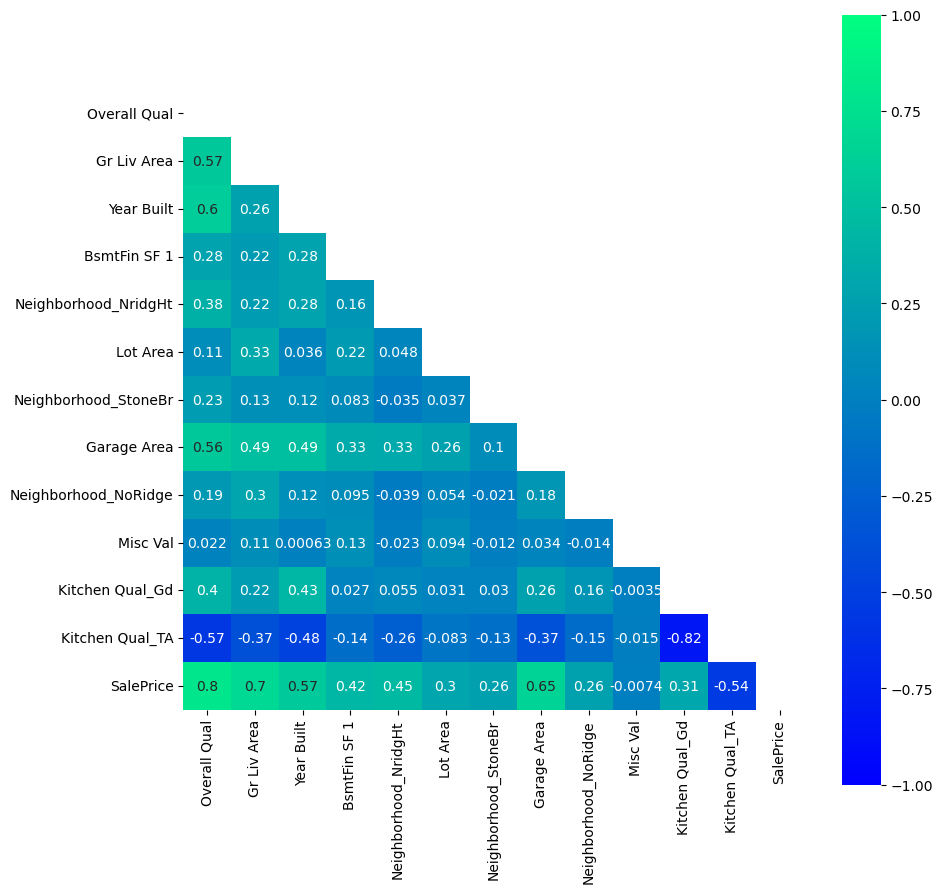

In [69]:
mask = np.zeros_like(homes_4.drop(columns = 'Id').corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (10, 10))
sns.heatmap(homes_4.drop(columns = 'Id').corr(),
           vmin = -1,
           vmax = 1,
           square = True,
           cmap = 'winter',
           annot = True,
           mask = mask);

Looking at the heatmap above, I noticed that a kitchen quality of typical or average has strong negative correlations with overal quality, year built, and good kitchen quality. The only other strongly correlated feature might be year built which is strongly positively correlated with garage area and overall quality. After performing the LASSO cross-validation one more time, I will consider whether to eliminate these two features for Model 5 or whether to eliminate features with low magnitude coefficients.

In [70]:
# call LASSO coefficient function
coefs_lasso_4 = get_lasso_cv(X_train, y_train)

coefs_lasso_4

Overall Qual            27204.001637
Gr Liv Area             20542.233440
Neighborhood_NridgHt    10126.138977
Year Built               9822.390675
BsmtFin SF 1             9513.137848
Neighborhood_StoneBr     7662.789765
Garage Area              7220.664193
Lot Area                 7199.330886
Neighborhood_NoRidge     6158.495008
Misc Val                -6432.441768
Kitchen Qual_Gd        -11499.396153
Kitchen Qual_TA        -15389.498596
dtype: float64

In [71]:
# print LASSO evaluation scores
print(f"Model 4 LASSO Optimal Alpha: {lasso_cv_pipe['lasso_cv'].alpha_}")
print(f'Model 4 LASSO Optimal Alpha Training Score: {lasso_cv_pipe.score(X_train, y_train)}')
print(f'Model 4 LASSO Optimal Alpha Test Score: {lasso_cv_pipe.score(X_test, y_test)}')

Model 4 LASSO Optimal Alpha: 265.6087782946687
Model 4 LASSO Optimal Alpha Training Score: 0.8303160669993027
Model 4 LASSO Optimal Alpha Test Score: 0.870323247741904


LASSO cross-validation scores are still holding high and close. I could choose to eliminate the neighborhood of Northridge and miscellaneous value or I could eliminate the multicolinear variables from my heatmap above, year built and kitchen quality typical or average. I will try eliminating the multi-colinear variables first and see how the model performs.

In [72]:
# makes a list of all features with coefficients less than magnitude 6000
elim_features = ['Year Built', 'Kitchen Qual_TA']
features_5 = [feature for feature in list(coefs_lasso_4.index) if feature not in elim_features]

features_5

['Overall Qual',
 'Gr Liv Area',
 'Neighborhood_NridgHt',
 'BsmtFin SF 1',
 'Neighborhood_StoneBr',
 'Garage Area',
 'Lot Area',
 'Neighborhood_NoRidge',
 'Misc Val',
 'Kitchen Qual_Gd']

In [73]:
X = homes_prelim[features_5]
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_5 = get_lr(X_train, y_train)

coefs_5

Overall Qual            33480.927619
Gr Liv Area             20427.023314
Neighborhood_NridgHt    13139.885988
BsmtFin SF 1            11113.347092
Garage Area              9336.595471
Neighborhood_StoneBr     9208.037171
Lot Area                 6852.234103
Neighborhood_NoRidge     6381.906136
Kitchen Qual_Gd          1760.779789
Misc Val                -6715.699572
dtype: float64

In [74]:
print(f'Model 5 Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Model 5 Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Model 5 Test Score: {ss_pipe.score(X_test, y_test)}')

Model 5 Cross-Validation Score: 0.7731944350263054
Model 5 Training Score: 0.8112832157401457
Model 5 Test Score: 0.8467370628151956


Eliminating those two potentially multi-colinear features has shown a small but noticeable drop in the cross-validation, training, and test scores of our models, all dropping approximately by 0.02 down to approximately 0.77, 0.81, and 0.85, respectively. As a result, I will go back to the previous Model 4 features and try to eliminate using my prior method of masking out those features whose coefficient magnitudes are lower in comparison to other features, using 7,000 as our threshold, eliminating the Northridge neighborhood and the miscellaneous value.

In [75]:
# makes a list of all features with coefficients less than magnitude 7000
features_5_new = coefs_lasso_4[abs(coefs_lasso_4) > 7000]

features_5_new

Overall Qual            27204.001637
Gr Liv Area             20542.233440
Neighborhood_NridgHt    10126.138977
Year Built               9822.390675
BsmtFin SF 1             9513.137848
Neighborhood_StoneBr     7662.789765
Garage Area              7220.664193
Lot Area                 7199.330886
Kitchen Qual_Gd        -11499.396153
Kitchen Qual_TA        -15389.498596
dtype: float64

In [76]:
X = homes_prelim[features_5_new.index]
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_5_new = get_lr(X_train, y_train)

coefs_5_new

Overall Qual            27356.604350
Gr Liv Area             21787.539078
Year Built              10459.061983
Neighborhood_NridgHt     9586.373655
BsmtFin SF 1             8800.786646
Garage Area              7904.537399
Neighborhood_StoneBr     7484.675360
Lot Area                 6577.549046
Kitchen Qual_Gd        -12337.516247
Kitchen Qual_TA        -16270.678176
dtype: float64

In [77]:
print(f'Model 5 Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Model 5 Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Model 5 Test Score: {ss_pipe.score(X_test, y_test)}')

Model 5 Cross-Validation Score: 0.789812043704689
Model 5 Training Score: 0.817118056561995
Model 5 Test Score: 0.8723793694173341


Looking at these metrics, this cross-validation score is relatively consistent with Model 4 at about 0.79. However, there is a small dip in the training score from approximately 0.83 to 0.82. The test score remained consistent at about 0.87. Model 5 saw some marginal losses in terms of evaluation metrics. However, I have arrived at a model pared down to somwhere between 10 and 12 features. Four of those features are related directly to our problem statement of which new home construction features should be maximized in layout and design to maximize sale price. For the finaly production model I will attempt to eliminate any features not directly relevant to the problem statement or any which features which ought to be held constant for the purposes of the question at hand.

---

## Production Model

In our final production model, I will include the top four area measurements most positively correlated with sale price, ground floor living area, finished basement square footage, garage area, and lot area. Since overall quality and year built are also highly positively correlated in all our iterated models, I will include them in the final production model, especially since we can presume for new construction projects that overall quality and year built will be more or less held constant and presumably both will be higher than most of the older constructed homes for sale on the market. Lastly, since the final production model is not concerned with neighborhood and kitchen quality was somewhat correlated with overall quality in our heatmap above, I can presume that we can potentially remove these feature to simplify our model and ensure that we are able to make geographically agnostic decisions, whenever possible.

In [78]:
production_features = ['Overall Qual', 'Gr Liv Area', 'Year Built', 'BsmtFin SF 1', 'Garage Area', 'Lot Area']
X = homes_prelim[production_features]
y = homes_prelim['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

coefs_production = get_lr(X_train, y_train)

coefs_production

Overall Qual    35143.958468
Gr Liv Area     22999.960314
Year Built      10528.397422
BsmtFin SF 1    10116.465289
Garage Area      8824.518777
Lot Area         6770.160991
dtype: float64

In [79]:
print(f'Production Model Cross-Validation Score: {cross_val_score(ss_pipe, X_train, y_train).mean()}')
print(f'Production Model Training Score: {ss_pipe.score(X_train, y_train)}')
print(f'Production Model Test Score: {ss_pipe.score(X_test, y_test)}')

Production Model Cross-Validation Score: 0.7544171412819313
Production Model Training Score: 0.7802646444079648
Production Model Test Score: 0.8415366207107722


In this final production model, we can see that the evaluation metrics are a bit lower than in either models 4 or 5, with a drop from about 0.83 to 0.78 in the training score and from about 0.87 to 0.84 in the test scores. This means somewhere between a 3-5% decrease in variability in home prices which can be explained by our final production model in comparison to models 4 or 5. However, this simplified six feature model has eliminated some extraneous factors which are somewhat irrelevant to our problem statement while overall quality and year build constant, both of which we can presume would be held constant for most of our new construction.

I will now create a simplified six feature dataframe of homes and save the file to our datasets.

In [80]:
homes_production_features = ['Id', 
                             'Overall Qual', 
                             'Gr Liv Area', 
                             'Year Built', 
                             'BsmtFin SF 1', 
                             'Garage Area', 
                             'Lot Area', 
                             'SalePrice'
                            ]

homes_production = homes_prelim[homes_production_features]

homes_production.head()

,Id,Overall Qual,Gr Liv Area,Year Built,BsmtFin SF 1,Garage Area,Lot Area,SalePrice
0,109,6,1479,1976,533.0,475.0,13517,130500
1,544,7,2122,1996,637.0,559.0,11492,220000
2,153,5,1057,1953,731.0,246.0,7922,109000
3,318,5,1444,2006,0.0,400.0,9802,174000
4,255,6,1445,1900,0.0,484.0,14235,138500


In [81]:
homes_production.to_csv('../datasets/homes_production.csv', index = False)

---

## Noteboook Conclusion

In this notebook, we ran through several iterations of our model, beginning with the preliminary model holding 27 features into consideration, of which 18 were related to the area or square footage of different home features. In our final production model, the top four most salient area features are considered to perform well as highly inferential and predictive measures of Ames home sale prices, holding the overall quality and year built constant. In the next notebook, I will continue to evaluate the production model and make final business recommendations.

In [ ]:
kaggle_features = []
for feature in features:
    kaggle_features.append(feature)
kaggle_features.append('SalePrice')

kaggle_train = homes_train[kaggle_features]

kaggle_train.to_csv('../datasets/kaggle_train_submission.csv', index = False)